# Customer Segments

In this notebook I will try to find possible customer segmenetation enabling to classify customers according the their different purchases. I hope this information will be useful for the next prediction task. 
Since there are thousands of products I will rely on aisles which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easy. I will then try to find explanations for the identified clusters.

## First Exploration

In [34]:

import numpy as np 
import pandas as pd 
pd.options.display.max_rows = 999
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

aisles.csv
departments.csv
groupby_features_test.pkl
groupby_features_train.pkl
kernel38-data.pkl
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv
test_dataset.pkl
train.csv
train_dataset.pkl
zip



In [9]:
orders = pd.read_csv('../input/orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [10]:
prior = pd.read_csv('../input/order_products__prior.csv')
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [11]:
train = pd.read_csv('../input/order_products__train.csv')
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


users, identified by user_id in the orders csv, make orders which are identified by order_id;

each order of a user is characterized by an order_number which specifies when it has been made with respect to the others of the same user;

each order consists of a set of product each characterized by an add_to_cart_order feature representing the sequence in which they have been added to the cart in that order

for each user we may have n-1 prior orders and 1 train order OR n-1 prior orders and 1 test order in which we have to state what products have been reordered

In [12]:
print(prior.shape)
print(orders.shape)
print(train.shape)

(32434489, 4)
(3421083, 7)
(1384617, 4)


In [13]:
##Due to the number of rows I have to reduce the set of prior data to publish the kernel 
##comment this if you can
prior = prior[0:300000]


In [14]:
order_prior = pd.merge(prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
221645,23391,13198,1,1,7,prior,17,0,10,28.0
221646,23391,42803,2,1,7,prior,17,0,10,28.0
221647,23391,8277,3,1,7,prior,17,0,10,28.0
221648,23391,37602,4,1,7,prior,17,0,10,28.0
221649,23391,40852,5,1,7,prior,17,0,10,28.0


In [15]:
products = pd.read_csv('../input/products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [35]:
aisles = pd.read_csv('../input/aisles.csv')
aisles

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [17]:
print(aisles.shape)

(134, 2)


In [18]:
_mt = pd.merge(prior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs


In [19]:
mt['product_name'].value_counts()[0:10]

Banana                    4432
Bag of Organic Bananas    3563
Organic Strawberries      2370
Organic Baby Spinach      2242
Organic Hass Avocado      1985
Organic Avocado           1626
Large Lemon               1380
Strawberries              1343
Organic Raspberries       1293
Limes                     1270
Name: product_name, dtype: int64

In [20]:
len(mt['product_name'].unique())

24836

In [21]:
prior.shape

(300000, 4)

## Clustering Customers

There are 143 types of product (aisle).

In [22]:
len(mt['aisle'].unique())

134

Fresh fruits and fresh vegetables are the best selling goods.

In [23]:
mt['aisle'].value_counts()[0:10]

fresh fruits                     33755
fresh vegetables                 31004
packaged vegetables fruits       16319
yogurt                           13477
packaged cheese                   9133
milk                              8254
water seltzer sparkling water     7634
chips pretzels                    6581
soy lactosefree                   5965
bread                             5457
Name: aisle, dtype: int64

I want to find a possible clusters among the different customers and substitute single user_id with the cluster to which they are assumed to belong. Hope this would eventually increase the model performance.

Ths first thing to do is creating a dataframe with all the purchases made by each user

In [24]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,4
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)


In [26]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5
0,-0.286251,1.005868,-1.030293,-0.899052,-0.587568,-0.998883
1,-1.972748,-0.487659,-0.120542,0.213089,0.045933,-0.181898
2,-1.168974,1.284089,3.228124,0.594016,-0.648822,-1.091869
3,-1.433967,1.250081,3.261985,1.237707,-0.353511,-0.346516
4,-2.070709,-0.422148,-0.101553,0.278228,0.005883,-0.097401


(25831, 2)
          4         1
0 -0.587568  1.005868
1  0.045933 -0.487659
2 -0.648822  1.284089
3 -0.353511  1.250081
4  0.005883 -0.422148


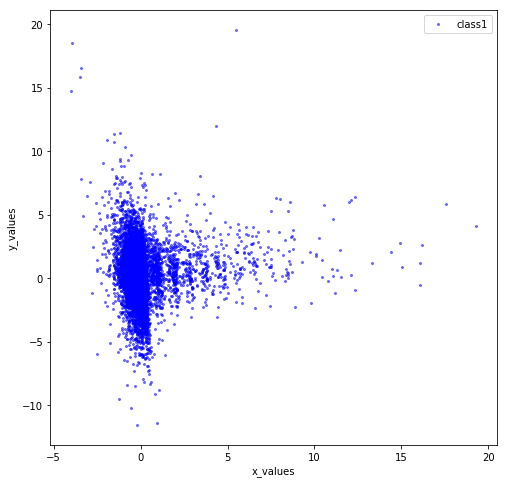

In [27]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[4,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[-0.00792832 -2.39936986]
 [-0.04626517 -0.15452148]
 [-0.24952605  2.06102735]
 [ 5.55592826  1.45663525]]


In [29]:
print (c_preds[0:100])

[2 1 2 2 1 1 1 1 1 1 0 1 2 1 1 3 1 1 2 1 1 1 1 1 1 2 0 1 1 2 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1
 2 2 0 1 1 1 1 1 2 2 1 1 0 2 1 1 1 1 1 2 1 1 2 1 1 1]


['purple', 'blue', 'purple', 'purple', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']


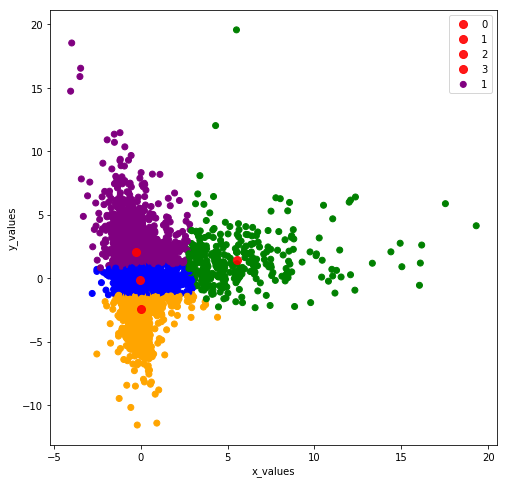

In [30]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

We have found a possible clustering for our customers. Let's check if we also manage to find some interesting pattern beneath it.

In [31]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
13,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,4,2
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,4,2
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
66,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
67,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


(25831, 135)


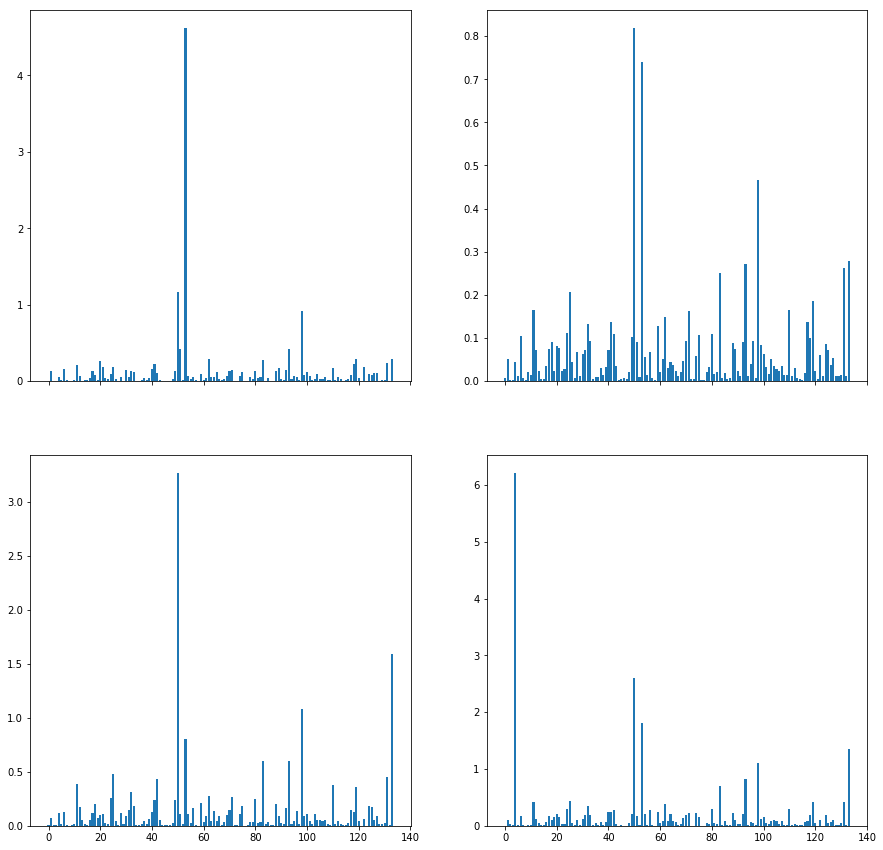

In [32]:
print (clust_prod.shape)
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()


Let's check out what are the top 10 goods bought by people of each cluster. We are going to rely first on the absolute data and then on a percentage among the top 8 products for each cluster.

In [25]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh vegetables              4.620428
fresh fruits                  1.163216
packaged vegetables fruits    0.922015
packaged cheese               0.423395
fresh herbs                   0.421670
soy lactosefree               0.288475
yogurt                        0.287095
frozen produce                0.282264
milk                          0.279848
canned jarred vegetables      0.261560
dtype: float64

In [26]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     0.818765
fresh vegetables                 0.739032
packaged vegetables fruits       0.465411
yogurt                           0.278152
packaged cheese                  0.271190
water seltzer sparkling water    0.262847
milk                             0.249641
chips pretzels                   0.205824
soy lactosefree                  0.185766
refrigerated                     0.164825
dtype: float64

In [27]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     3.268080
yogurt                           1.592411
packaged vegetables fruits       1.078795
fresh vegetables                 0.802455
packaged cheese                  0.603571
milk                             0.597768
chips pretzels                   0.481696
water seltzer sparkling water    0.452009
energy granola bars              0.432812
bread                            0.383705
dtype: float64

In [28]:
c3.sort_values(ascending=False)[0:10]

aisle
baby food formula                6.214085
fresh fruits                     2.605634
fresh vegetables                 1.814085
yogurt                           1.343662
packaged vegetables fruits       1.101408
packaged cheese                  0.828169
milk                             0.695775
chips pretzels                   0.430986
water seltzer sparkling water    0.419718
soy lactosefree                  0.419718
dtype: float64

A first analysis of the clusters confirm the initial hypothesis that:

* fresh fruits                     
* fresh vegetables                 
* packaged vegetables fruits       
* yogurt                           
* packaged cheese                   
* milk                              
* water seltzer sparkling water     
* chips pretzels                    

are products which are genereically bought by the majority of the customers.

What we can inspect here is if clusters differ in quantities and proportions, with respect of these goods, or if a cluster is characterized by some goods not included in this list. For instance we can already see cluster 3 is characterized by 'Baby Food Formula' product which is a significant difference with respect to the other clusters.

In [29]:
from IPython.display import display, HTML
cluster_means = [[c0['fresh fruits'],c0['fresh vegetables'],c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'],c0['water seltzer sparkling water'],c0['chips pretzels']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns = ['fresh fruits','fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
HTML(cluster_means.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,1.163216,4.620428,0.922015,0.287095,0.423395,0.279848,0.242581,0.188061
1,0.818765,0.739032,0.465411,0.278152,0.271190,0.249641,0.262847,0.205824
2,3.268080,0.802455,1.078795,1.592411,0.603571,0.597768,0.452009,0.481696
3,2.605634,1.814085,1.101408,1.343662,0.828169,0.695775,0.419718,0.430986


The following table depicts the percentage these goods with respect to the other top 8 in each cluster. It is easy some interesting differences among the clusters. 

It seems people of cluster 1 buy more fresh vegetables than the other clusters. As shown by absolute data, Cluster 1 is also the cluster including those customers buying far more goods than any others.

People of cluster 2 buy more yogurt than people of the other clusters.

Absolute Data shows us People of cluster 3 buy a Lot of 'Baby Food Formula' which not even listed in the top 8 products but mainly characterize this cluster. Coherently (I think) with this observation they buy more milk than the others.

In [30]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
HTML(cluster_perc.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,14.313617,56.855335,11.345590,3.532759,5.209970,3.443591,2.985011,2.314127
1,24.879949,22.457101,14.142517,8.452265,8.240707,7.585883,7.987172,6.254407
2,36.816033,9.039932,12.152987,17.939046,6.799437,6.734058,5.092034,5.426474
3,28.201220,19.634146,11.920732,14.542683,8.963415,7.530488,4.542683,4.664634


I think another interesting information my come by lookig at the 10th to 15th most bought products for each cluster which will not include the generic products (i.e. vegetables, fruits, water, etc.) bought by anyone.

In [31]:
c0.sort_values(ascending=False)[10:15]

aisle
water seltzer sparkling water    0.242581
eggs                             0.226363
soup broth bouillon              0.226363
bread                            0.213251
canned meals beans               0.188751
dtype: float64

In [32]:
c1.sort_values(ascending=False)[10:15]

aisle
bread             0.164272
ice cream ice     0.163499
frozen produce    0.149685
eggs              0.137308
soft drinks       0.136534
dtype: float64

In [33]:
c2.sort_values(ascending=False)[10:15]

aisle
refrigerated       0.381696
soy lactosefree    0.361161
crackers           0.308705
frozen produce     0.277679
ice cream ice      0.266295
dtype: float64

In [34]:
c3.sort_values(ascending=False)[10:15]

aisle
bread             0.414085
frozen produce    0.388732
crackers          0.352113
cereal            0.304225
refrigerated      0.301408
dtype: float64

As you can note by taking into account more products clusters start to differ significantly. I hope this informtion will be useful in the next prediction task.